In [ ]:
!pip install geopandas
!pip install --upgrade matplotlib

import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# # https://drive.google.com/file/d/1wajcswSykeYTIxum4YyjsXwgOYLtpTll/view?usp=sharing
# id = "1wajcswSykeYTIxum4YyjsXwgOYLtpTll"
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('CALosAngeles1939.geojson')  
# gdf = geopandas.read_file('CALosAngeles1939.geojson')

# https://drive.google.com/file/d/1M5VS8I15s9trq_sfd5bCJq5PBEgKcYb6/view?usp=sharing
id = "1M5VS8I15s9trq_sfd5bCJq5PBEgKcYb6"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dict.csv')
cols = ['key', 'bin']
mapping_to_bin = pd.read_csv('dict.csv', names=cols)

# https://drive.google.com/file/d/17fjlSvgE31BSdjJQpEEuO5ihaLObnBN6/view?usp=sharing
id = "17fjlSvgE31BSdjJQpEEuO5ihaLObnBN6"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('predpol_drug_predictions.csv')
predictions = pd.read_csv('predpol_drug_predictions.csv')


Getting HOLC ID and HOLC Grade based on LAT/LONG

In [ ]:
# print(type(gdf))
# print(gdf.shape)
# print(gdf.columns)

# print(gdf['geometry'])

# # point: geopandas point
# def get_holc_id_rating(point):
#   for index,row in gdf.iterrows():
#     if row.geometry.contains(point):
#       return (row.holc_id, row.holc_grade)
#   return (-1, -1)

**bold text**
La County split into 150x150 bins
long, lat -> bin (10m)
 ---> taking bins with only a crime, renumbering them into keys (mapped to number between 1 - 10m)

In [ ]:
import math
print(mapping_to_bin.head())
print(mapping_to_bin.loc[mapping_to_bin["key"] == 3].iloc[0]["bin"])

# Mapping Keys back to Bin Number
def key_to_bin(key):
  return int(mapping_to_bin.loc[mapping_to_bin["key"] == key].iloc[0]["bin"])

min_lat = 33.317
max_lat = 34.830
min_long = -119.936
max_long = -117.352
"""
# redefine necessary constants


# 111,111 m/deg * deg * bin/150m
num_lat_bins = int((max_lat - min_lat) * 111111/150)
num_long_bins = int((max_long - min_long) * math.cos(math.radians(max_lat)) * 111111/150)
print(num_lat_bins)
print(num_long_bins)
def get_bin(long, lat):
  lat_coord = int((float(lat) - min_lat) * 111111/150)
  long_coord = int((float(long) - min_long) * math.cos(math.radians(float(lat))) * 111111/150)
  return lat_coord * num_long_bins + long_coord
"""

# Grabbing center of bin, Lat, Long
def bin_to_lat_long(bin):
  num_long_bins = int((max_long - min_long) * math.cos(math.radians(max_lat)) * 111111/150)
  num_lat_bins = int((max_lat - min_lat) * 111111/150)
  long_coord = bin % num_long_bins
  lat_coord = bin // num_long_bins
  
  lat = (lat_coord / (111111/150)) + min_lat + (75/111111)
  long = (long_coord / (math.cos(math.radians(float(lat))) * 111111/150)) + min_long + (75/111111)
  return (long, lat)
print(bin_to_lat_long(794543))

   key      bin
0  NaN        0
1  0.0   964151
2  1.0  1171305
3  2.0   819705
4  3.0   648349
648349.0
(-118.00080379836078, 33.99942568242568)


In [ ]:
odds_to_police = .05

# prediction.columns = dates for year
# Going though every data and bin, checking threshold, to find ... 
bins_policed_dict = {}
for column in predictions.columns:
  if column == "bin":
    continue
  if column == "2018-01-01":
    print(predictions[predictions[column] >= odds_to_police]['bin'])
    print(predictions[predictions[column] >= odds_to_police]['bin'].to_numpy())
  policed_bins = predictions[predictions[column] >= odds_to_police]['bin'].to_numpy().tolist() # grabs bins greater than threshold for spefic day
  # add found bins to bins_policed_dict
  for bin in policed_bins:
    if bin in bins_policed_dict.keys():
      bins_policed_dict[bin] += 1
    else:
      bins_policed_dict[bin] = 1
# Time each bins is pooiced over a year
print(bins_policed_dict)

2          3
52        53
82        83
151      152
169      170
200      201
207      208
217      218
232      233
245      246
262      263
289      290
304      305
315      316
317      318
329      330
342      343
349      350
359      360
391      392
406      407
419      420
458      459
485      486
486      487
488      489
630      631
792      793
794      795
892      893
920      921
922      923
927      928
942      943
1059    1060
1136    1137
1369    1370
1384    1385
1436    1437
1502    1503
1944    1945
1948    1949
2066    2067
2773    2774
Name: bin, dtype: int64
[   3   53   83  152  170  201  208  218  233  246  263  290  305  316
  318  330  343  350  360  392  407  420  459  486  487  489  631  793
  795  893  921  923  928  943 1060 1137 1370 1385 1437 1503 1945 1949
 2067 2774]
{3: 230, 53: 95, 83: 60, 152: 338, 170: 37, 201: 248, 208: 364, 218: 364, 233: 165, 246: 364, 263: 236, 290: 94, 305: 1, 316: 350, 318: 184, 330: 10, 343: 364, 350: 364, 360: 335,

In [ ]:
from shapely.geometry import Point
bins_policed_list = list(bins_policed_dict.keys())
bins_policed_frequency = []

# splitting bins policed list into two lists
for bin in bins_policed_list:
  bins_policed_frequency.append(bins_policed_dict[bin])

d = {
    'key': bins_policed_list,
    'freq': bins_policed_frequency
}

# Turning into dataframe
df_freq = pd.DataFrame(data=d)

# items_df['Final Price'] = items_df.apply(
    #lambda row: row.Actual_Price - ((row.Discount_Percentage/100)*row.Actual_Price), axis=1)

# Add new column called bin, that maps keys to corresponding bins
df_freq["bin"] = df_freq.apply(lambda row: key_to_bin(row.key), axis=1)
print(df_freq.head())

# Add Point and Frequency, Remove everything else
df_freq["longlat"] = df_freq.apply(lambda row: bin_to_lat_long(row.bin), axis=1)
df_freq["long"] = df_freq.apply(lambda row: row.longlat[0], axis=1)
df_freq["lat"] = df_freq.apply(lambda row: row.longlat[1], axis=1)
df_freq["point"] = df_freq[["long", "lat"]].apply(Point, axis=1)
df_freq = df_freq.drop("longlat", 1)
df_freq = df_freq.drop("long", 1)
df_freq = df_freq.drop("lat", 1)
df_freq = df_freq.drop("key", 1)
 # df_freq = df_freq.drop("bin", 1)

print(df_freq.head())
print(df_freq.columns)





   key  freq     bin
0    3   230  648349
1   53    95  615325
2   83    60  731488
3  152   338  714245
4  170    37  833721
   freq     bin                                         point
0   230  648349  POINT (-118.1516188415506 33.87387555687556)
1    95  615325  POINT (-118.2058506246569 33.84552552852553)
2    60  731488  POINT (-118.3519124069183 33.94542562842563)
3   338  714245   POINT (-118.290359993646 33.93057561357561)
4    37  833721  POINT (-118.1580506913776 34.03317571617572)
Index(['freq', 'bin', 'point'], dtype='object')


In [ ]:
# # add corresonding stuff
# df_freq["holc"] = df_freq.apply(lambda row: get_holc_id_rating(row.point), axis=1)
# df_freq["holc_id"] = df_freq.apply(lambda row: row.holc[0], axis=1)
# df_freq["holc_rating"] = df_freq.apply(lambda row: row.holc[1], axis=1)

# print(df_freq.head())
# print(df_freq.columns)

# df_freq = df_freq.drop("holc", 1)

# # remove points that don't fall within red-lined area
# df_freq = df_freq[df_freq["holc_id"] != -1]

# ratings = ['A', 'B', 'C', 'D']
# sum_freqs = [0, 0, 0, 0]

# # bar graph stuff
# for index,row in df_freq.iterrows():
#   sum_freqs[ratings.index(row.holc_rating)] += row.freq

# freq_arr = np.array(sum_freqs)

# # find proprotion
# freq_arr = freq_arr / np.sum(freq_arr)
# print(freq_arr)



#geom = geopandas.points_from_xy(df_freq.long, df_freq.lat, crs="EPSG:4326")


#gdf_freq = geopandas.GeoDataFrame(
#   df_freq, geometry=geom)



# for index, row in df_freq.iterrows():
#     row["bin"] = key_to_bin(row["key"])

# print(df_freq.head())


In [ ]:
# fig = plt.figure()
# fig.patch.set_facecolor('white')

# ax = fig.add_axes([0,0,1,1])
# a1 = ax.bar(ratings,freq_arr)
# ax.bar_label(a1, fmt="%.3f", label_type='edge')

# plt.ylim(0, 1)
# plt.title(f"Proportion of Policing by HOLC Rating (threshold = {odds_to_police})")
# plt.xlabel("HOLC Rating")
# plt.ylabel("Percentage of Total Deployments per HOLC Rating")
# plt.show()

**Setting Census Geomapping** 


In [ ]:
df_freq.shape

(66, 3)

In [ ]:
# to give more power to your figures (plots)
import matplotlib.pyplot as plt
import os
gdf1 = geopandas.read_file("/content/acs2019_5yr_B03002_14000US06037275603.geojson")

In [ ]:
# dropping county level
gdf1 = gdf1.drop([0])

# choosing race
columns_to_keep = ['geoid',
 'name',
 'B03002001',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002009',
 'B03002012',
 'geometry']

# redefine gdf with only columns to keep
gdf1 = gdf1[columns_to_keep]


In [ ]:
# rename columns 
list(gdf1) # this is the same as df.columns.to_list()

gdf1.columns = ['geoid',
 'name',
 'Total',
 'White',
 'Black',
 'American indian/Alaska Native',
 'Asian',
 'Native Hawaiian and Other Pacific Islander',
 'Non Hispanic Two or more races',
 'Hispanic',
 'geometry']
# check the renamed columns
gdf1.head()

,geoid,name,Total,White,Black,American indian/Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Non Hispanic Two or more races,Hispanic,geometry
1,14000US06037101110,"Census Tract 1011.10, Los Angeles, CA",4283.0,2616.0,19.0,3.0,331.0,3.0,115.0,1188.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
2,14000US06037101122,"Census Tract 1011.22, Los Angeles, CA",3405.0,2882.0,74.0,15.0,220.0,0.0,67.0,147.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
3,14000US06037101210,"Census Tract 1012.10, Los Angeles, CA",6347.0,2986.0,198.0,0.0,486.0,0.0,14.0,2616.0,"MULTIPOLYGON (((-118.29945 34.25598, -118.2979..."
4,14000US06037101220,"Census Tract 1012.20, Los Angeles, CA",3702.0,1812.0,87.0,0.0,341.0,0.0,98.0,1364.0,"MULTIPOLYGON (((-118.28593 34.25227, -118.2859..."
5,14000US06037101300,"Census Tract 1013, Los Angeles, CA",3884.0,3126.0,205.0,0.0,194.0,0.0,62.0,297.0,"MULTIPOLYGON (((-118.27822 34.25068, -118.2782..."


**Baseline Demographic Analysis**

In [ ]:
# point: geopandas point, normalizing proportion of target demographic within each bin
def map_to_census_tract(point):
  for index,row in gdf1.iterrows():
    if row.geometry.contains(point):
      area = row.geometry.area

      white = ((150*150)/(area*10000)) * row.White
      black = ((150*150)/(area*10000)) * row.Black
      hispanic = ((150*150)/(area*10000)) * row.Hispanic
      return (white,black,hispanic, row.geometry)
  return (-1, -1, -1)

In [ ]:
# Map each Bin to a Census Block
df_freq["Demographics"] = df_freq.apply(lambda row: map_to_census_tract(row.point), axis=1)
# Number of Target Demographic Within Correspinding Bin
df_freq["white"] = df_freq.apply(lambda row: row.Demographics[0], axis=1)
df_freq["black"] = df_freq.apply(lambda row: row.Demographics[1], axis=1)
df_freq["hispanic"] = df_freq.apply(lambda row: row.Demographics[2], axis=1)
df_freq["geometry"] = df_freq.apply(lambda row: row.Demographics[3], axis=1)

df_freq = df_freq.drop("Demographics", 1)

# Total Populations
Total_White_Pop = 7027375
Total_Black_Pop = 903512
Total_Latino_Pop = 4879006

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1591: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1591: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  result[:] = values
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:385: ShapelyDeprecation

In [ ]:
black_sum = 0
white_sum = 0
hispanic_sum = 0

# check if bin is above threshold, gather race data
# First Equation from our paper
for index, row in df_freq.iterrows():
  if row.freq >= odds_to_police:
    black_sum += row.black
    white_sum += row.white
    hispanic_sum += row.hispanic

b = black_sum / Total_Black_Pop
w = white_sum / Total_White_Pop
l = hispanic_sum / Total_Latino_Pop

print(b)
print(w)
print(l)

943.480018526485
112.45808083591653
702.478846695433


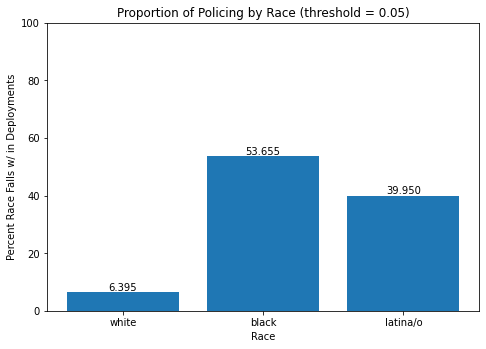

In [ ]:
# Plotting
sum = b + w + l

races = ['white', 'black', 'latina/o']
nums = [w/sum * 100, b/sum * 100, l/sum * 100]

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_axes([0,0,1,1])
a1 = ax.bar(races,nums)
ax.bar_label(a1, fmt="%.3f", label_type='edge')

plt.ylim(0, 100)
plt.title(f"Proportion of Policing by Race (threshold = {odds_to_police})")
plt.xlabel("Race")
plt.ylabel("Percent Race Falls w/ in Deployments")
plt.show()

**Replacing Threshold w/ Success Rate**

In [ ]:
# Grabbing Crime Data for 2019

df_2019 = pd.read_csv("/content/LACRIMES_2019.csv")

# removing category 2 crimes, more violent charges that don't have drug data
df_2019.drop(df_2019[df_2019['PART_CATEGORY'] == 1 ].index , inplace=True)

# grabbing crime data specifically // 201, 202, 241, 242, 243, 244, 245, 495, 743, 181 - 189
values = [201, 202, 241, 242, 243, 244, 245, 495, 743, 181, 182, 183, 184, 185, 186, 187, 188, 189]
df_2019 = df_2019[df_2019.STAT.isin(values)]

# Remove columns we don't need for prediction
df_2019 = df_2019.drop('PART_CATEGORY', 1)
df_2019 = df_2019.drop('CATEGORY', 1)
df_2019 = df_2019.drop('STAT_DESC', 1)
df_2019 = df_2019.drop('INCIDENT_ID', 1)

In [ ]:
# Setting Date Time
df_2019['INCIDENT_DATE'] = pd.to_datetime(df_2019['INCIDENT_DATE'])
df_2019.set_index('INCIDENT_DATE', inplace=True)
df_2019.sort_index(inplace=True)

df_2019['month'] = df_2019.index.month
df_2019['year'] = df_2019.index.year
df_2019['day'] = df_2019.index.day
df_2019['crimes'] = 1

# Some Incident dates are outside of yearly bounds
# Some crimes are not within 2019.
df_2019 = df_2019[df_2019.index > '2018-12-31']

# Add our points
from shapely.geometry import Point
df_2019["point"] = df_2019[["LONGITUDE", "LATITUDE"]].apply(Point, axis=1)

df_2019 = df_2019.drop('LONGITUDE', 1)
df_2019 = df_2019.drop('LATITUDE', 1)
df_2019.head()

,INCIDENT_REPORTED_DATE,STAT,ADDRESS,STREET,CITY,ZIP,REPORTING_DISTRICT,UNIT_NAME,month,year,day,crimes,point
INCIDENT_DATE,,,,,,,,,,,,,
2019-01-01 00:25:00,01/01/2019,242,"SUNSET BLVD AND SWEETZER AVE, WEST HOLLYWOOD, CA",SUNSET BLVD AND SWEETZER AVE,WEST HOLLYWOOD,NaN,987,WEST HOLLYWOOD,1,2019,1,1,POINT (-118.37 34.096)
2019-01-01 00:53:00,01/01/2019,185,"22400 S CAROLDALE AVE, CARSON, CA",22400 S CAROLDALE AVE,CARSON,NaN,1623,CARSON,1,2019,1,1,POINT (-118.284 33.822)
2019-01-01 00:54:00,01/01/2019,185,"186TH ST AND CROCKER AVE, CARSON, CA",186TH ST AND CROCKER AVE,CARSON,NaN,1614,CARSON,1,2019,1,1,POINT (-118.268 33.861)
2019-01-01 01:30:00,01/01/2019,201,"100 BLK OF SUMNER AVE, AVALON, CA",100 BLK OF SUMNER AVE,AVALON,NaN,1811,AVALON,1,2019,1,1,POINT (nan nan)
2019-01-01 02:07:00,01/01/2019,242,"8700 VALLEY BLVD, ROSEMEAD, CA 91770",8700 VALLEY BLVD,ROSEMEAD,91770.0,530,TEMPLE,1,2019,1,1,POINT (-118.078 34.081)


**Warning: This next part takes 500 years to run (8 min)**

In [ ]:
# Mapping Crimes to Bins
def find_crime_freq(geom):
  sum = 0
  for index,row in df_2019.iterrows():
    if geom.contains(row.point):
      sum = sum + 1
  return sum

df_freq["tot crime"] = df_freq.apply(lambda row: find_crime_freq(row.geometry), axis=1)

df_freq.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:385: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.py:119: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.p

,freq,bin,point,white,black,hispanic,geometry,tot crime
0,230,648349,POINT (-118.1516188415506 33.87387555687556),2.456177e+07,3.100766e+07,9.496096e+07,"(POLYGON ((-118.159981 33.874684, -118.158899 ...",0
1,95,615325,POINT (-118.2058506246569 33.84552552852553),6.530594e+06,9.814133e+06,4.998276e+07,"(POLYGON ((-118.207657 33.839452, -118.207563 ...",0
2,60,731488,POINT (-118.3519124069183 33.94542562842563),2.370146e+05,2.986384e+06,1.284619e+08,"(POLYGON ((-118.356967 33.942603, -118.356963 ...",30
3,338,714245,POINT (-118.290359993646 33.93057561357561),6.942866e+05,4.100258e+07,6.730613e+07,"(POLYGON ((-118.291641 33.938204, -118.289364 ...",19
4,37,833721,POINT (-118.1580506913776 34.03317571617572),3.432207e+06,0.000000e+00,7.905912e+07,"(POLYGON ((-118.15978 34.025684, -118.159499 3...",29


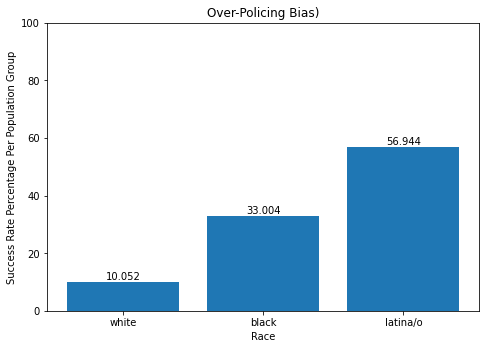

In [ ]:
black_sum1 = 0
white_sum1 = 0
hispanic_sum1 = 0

# Equation from Paper
for index, row in df_freq.iterrows():
    black_sum1 += (row['tot crime']/row.freq) * row.black
    white_sum1 += (row['tot crime']/row.freq) * row.white
    hispanic_sum1 += (row['tot crime']/row.freq) * row.hispanic

b1 = black_sum1 / Total_Black_Pop
w1 = white_sum1 / Total_White_Pop
l1 = hispanic_sum1 / Total_Latino_Pop

# Plotting
sum1 = b1 + w1 + l1

races = ['white', 'black', 'latina/o']
nums = [w1/sum1 * 100, b1/sum1 * 100, l1/sum1 * 100]

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_axes([0,0,1,1])
a1 = ax.bar(races,nums)
ax.bar_label(a1, fmt="%.3f", label_type='edge')

plt.ylim(0, 100)
plt.title(f"Over-Policing Bias)")
plt.xlabel("Race")
plt.ylabel("Success Rate Percentage Per Population Group")
plt.show()
